## Importing the neccessary libraries






In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#https://github.com/avakanski/A-Deep-Learning-Framework-for-Assessing-Physical-Rehabilitation-Exercises/blob/master/Neural%20Networks/Dimensionality%20Reduction%20for%20Vicon/Autoencoder_Dims_Reduction.ipynb

Mounted at /content/drive


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import random
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import csv
import os,random
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Activation, Flatten
from keras.layers import LSTM, SimpleRNN, Bidirectional
from keras.layers import LeakyReLU
from keras.optimizers import *
from keras.callbacks import EarlyStopping
import csv
import os,random


import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow.keras.layers import Masking, LSTM, Dense


import datetime
now = datetime.datetime.now

! pip install numpy scikit-learn imbalanced-learn


In [ ]:

# Load from files
correct_data_arrays = np.load('/content/drive/MyDrive/Project_wrk/correct_data_3d.npy')
incorrect_data_arrays = np.load('/content/drive/MyDrive/Project_wrk/incorrect_data_3d.npy')

## Data Preprocessing for Uniform Arrays

In [ ]:
#setting the max_frames for both the correct and incorrect sequences as 500 for padding and truncating---then compare results
#I want to confirm if this is the right wau=y to padd and truncate the num of frames arrays
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to create 3D array with padding for correct sequences and truncation for incorrect sequences
def create_3d_array(data_arrays_list, max_frames=500):
    num_files = len(data_arrays_list)
    # Assuming all sequences have the same number of joints, take the number of joints from the first frame of the first sequence
    num_joints = len(data_arrays_list[0][0])

    # Initialize a 3D array with zeros
    data_3d = np.zeros((num_files, max_frames, num_joints))

    for i, sequence in enumerate(data_arrays_list):
        # Initialize a temporary list to store padded data for each joint
        padded_sequence = []

        for joint in range(num_joints):
            # Extract the joint data for the entire sequence
            joint_data = np.array([frame[joint] for frame in sequence])

            # Pad or truncate the joint data
            joint_padded = pad_sequences([joint_data], maxlen=max_frames, dtype='float32', padding='post', truncating='post')

            # Add the padded joint data to the temporary list
            padded_sequence.append(joint_padded[0])

        # Stack the padded data for all joints to form the final padded sequence
        data_3d[i] = np.stack(padded_sequence, axis=-1)

    return data_3d



# Create 3D arrays with padding for correct and truncation for incorrect
correct_data_3d = create_3d_array(correct_data_arrays)
incorrect_data_3d = create_3d_array(incorrect_data_arrays)




In [ ]:
correct_data_3d.shape

(2047, 500, 75)

In [ ]:
incorrect_data_3d.shape

(543, 500, 75)

In [ ]:

# Assigning  labels
correct_labels = np.ones(len(correct_data_3d))
incorrect_labels = np.zeros(len(incorrect_data_3d))

# Combine data and labels
correct_data = np.array(correct_data_3d)
incorrect_data = np.array(incorrect_data_3d)


Splitting the dataset using random indices

In [ ]:
# using the Sample random indices to split the data into train and split


# Determine the size of your correct and incorrect data
correct_data_size = len(correct_data)
incorrect_data_size = len(incorrect_data)

# Sample random indices for correct data
train_fraction = 0.7
correct_train_size = int(correct_data_size * train_fraction)

correct_train_idx = random.sample(range(0, correct_data_size), correct_train_size)
correct_valid_idx = np.setdiff1d(np.arange(0, correct_data_size, 1), correct_train_idx)

# Sample random indices for incorrect data
incorrect_train_size = int(incorrect_data_size * train_fraction)
incorrect_train_idx = random.sample(range(0, incorrect_data_size), incorrect_train_size)
incorrect_valid_idx = np.setdiff1d(np.arange(0, incorrect_data_size, 1), incorrect_train_idx)

# Training set: data and labels
train_x = np.concatenate((correct_data[correct_train_idx, :, :], incorrect_data[incorrect_train_idx, :, :]))
print(train_x.shape, 'training data')
train_y = np.concatenate((np.squeeze(correct_labels[correct_train_idx]), np.squeeze(incorrect_labels[incorrect_train_idx])))
print(train_y.shape, 'training labels')

# Validation set: data and labels
valid_x = np.concatenate((correct_data[correct_valid_idx, :, :], incorrect_data[incorrect_valid_idx, :, :]))
print(valid_x.shape, 'validation data')
valid_y = np.concatenate((np.squeeze(correct_labels[correct_valid_idx]), np.squeeze(incorrect_labels[incorrect_valid_idx])))
print(valid_y.shape, 'validation labels')


(1812, 500, 75) training data
(1812,) training labels
(778, 500, 75) validation data
(778,) validation labels


Including SMOTE analysis to balance the classes

In [ ]:
#since the classes are unbalanced using smote analysis to balance the classes

# Reshape the data to 2D
nr, n_frames, n_dim = train_x.shape
X_train_2d = train_x.reshape((nr, n_frames * n_dim))

# Apply SMOTENC
smote = SMOTE(random_state=42)
X_resampled_2d, y_resampled = smote.fit_resample(X_train_2d, train_y)
# Reshape the resampled data back to 3D
X_resampled = X_resampled_2d.reshape((len(X_resampled_2d), n_frames, n_dim))

# Separate resampled data and labels
correct_data_resampled = X_resampled[y_resampled == 1]
correct_labels_resampled = y_resampled[y_resampled == 1]
incorrect_data_resampled = X_resampled[y_resampled == 0]
incorrect_labels_resampled = y_resampled[y_resampled == 0]

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(X_resampled.shape)
print(y_resampled.shape)

(1812, 500, 75)
(1812,)
(2864, 500, 75)
(2864,)


In [ ]:
import seaborn as sns

# Visualize Original vs. Processed Data
plt.figure(figsize=(14, 8))

# Original Data
plt.subplot(2, 4, 1)
plt.plot(correct_data_arrays[5])
plt.title('Original First Train Sequence')
plt.subplot(2, 4, 2)
plt.plot(correct_data_arrays[-10])
plt.title('Original Last Train Sequence')

# Processed Data
plt.subplot(2, 4, 5)
plt.plot(train_x[5])
plt.title('Processed First Train Sequence')
plt.subplot(2, 4, 6)
plt.plot(train_x[-10])
plt.title('Processed Last Train Sequence')

plt.tight_layout()
plt.show()

In [ ]:

# Plot the first and last sequence in the training and resampled data
plt.figure(figsize = (14,4))
plt.subplot(2,2,1)
plt.plot(train_x[5])
plt.ylim([-0.5,1.5])
plt.xlim([0,100])
plt.title('First Train Sequence')
plt.subplot(2,2,2)
plt.plot(train_x[-10])
plt.ylim([-0.5,1.5])
plt.xlim([0,100])
plt.title('Last Train Sequence')
plt.subplot(2,2,3)
plt.plot(X_resampled[7])
plt.ylim([-0.5,1.5])
plt.xlim([0,100])
plt.title('First resampled Sequence')
plt.subplot(2,2,4)
plt.plot(X_resampled[56])
plt.ylim([-0.5,1.5])
plt.xlim([0,100])
plt.title('Last resampled Sequence')
plt.tight_layout()
plt.show()


Building the RNN network

In [ ]:

#building an RNN network
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(500, 75)))
model.add(Bidirectional(LSTM(30, recurrent_dropout = 0.5, return_sequences = True)))
model.add(Dropout(0.25))

model.add(Dense(30, activation = 'tanh'))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(10, recurrent_dropout = 0.5)))
model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation('sigmoid'))



In [ ]:
# keras.utils.plot_model(model, "my_first_model.png",show_shapes = True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 500, 75)           0         
                                                                 
 bidirectional (Bidirection  (None, 500, 60)           25440     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 500, 60)           0         
                                                                 
 dense (Dense)               (None, 500, 30)           1830      
                                                                 
 dropout_1 (Dropout)         (None, 500, 30)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 20)                3280      
 onal)                                                  

In [ ]:
metrics = [
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

In [ ]:
#improve on  compiling the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics= metrics,run_eagerly=True)

In [ ]:
model.summary()

In [ ]:
# Measure the training time and implement early stoping for the imbalanced dataset
t = now()

early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

history = model.fit(train_x,train_y, batch_size=300, epochs=50, verbose=2,
                         validation_data=(valid_x,valid_y),
                         callbacks = [early_stopping])
print('Training time: %s' % (now() - t))

Epoch 1/50
7/7 - 239s - loss: 0.2336 - precision: 0.9442 - recall: 0.9340 - accuracy: 0.9042 - val_loss: 0.2957 - val_precision: 0.8782 - val_recall: 0.9967 - val_accuracy: 0.8882 - 239s/epoch - 34s/step
Epoch 2/50
7/7 - 234s - loss: 0.2369 - precision: 0.9144 - recall: 0.9623 - accuracy: 0.8990 - val_loss: 0.2211 - val_precision: 0.9270 - val_recall: 0.9496 - val_accuracy: 0.9010 - 234s/epoch - 33s/step
Epoch 3/50
7/7 - 235s - loss: 0.2220 - precision: 0.9234 - recall: 0.9679 - accuracy: 0.9111 - val_loss: 0.2131 - val_precision: 0.9104 - val_recall: 0.9919 - val_accuracy: 0.9165 - 235s/epoch - 34s/step
Epoch 4/50
7/7 - 233s - loss: 0.2043 - precision: 0.9348 - recall: 0.9616 - accuracy: 0.9167 - val_loss: 0.1924 - val_precision: 0.9337 - val_recall: 0.9854 - val_accuracy: 0.9332 - 233s/epoch - 33s/step
Epoch 5/50
7/7 - 231s - loss: 0.2037 - precision: 0.9246 - recall: 0.9679 - accuracy: 0.9123 - val_loss: 0.1967 - val_precision: 0.9393 - val_recall: 0.9561 - val_accuracy: 0.9165 - 23

In [ ]:
# Get the maximum validation accuracy and its epoch
max_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(max_val_acc) + 1

# Get precision and recall corresponding to the best epoch
precision_at_best_epoch = history.history['val_precision'][best_epoch - 1]
recall_at_best_epoch = history.history['val_recall'][best_epoch - 1]

# Print or use the results
print(f"Best Validation Accuracy: {max_val_acc} at Epoch {best_epoch}")
print(f"Precision at Best Epoch: {precision_at_best_epoch}")
print(f"Recall at Best Epoch: {recall_at_best_epoch}")

Best Validation Accuracy: 0.9331619739532471 at Epoch 4
Precision at Best Epoch: 0.9337441921234131
Recall at Best Epoch: 0.9853658676147461


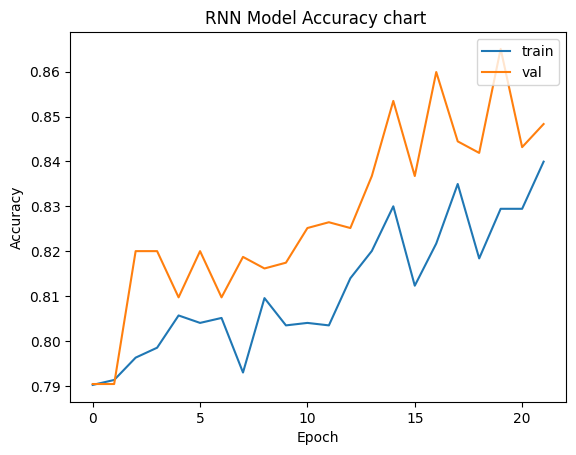

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("RNN Model Accuracy chart ")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "val"], loc = "upper right")
plt.show()

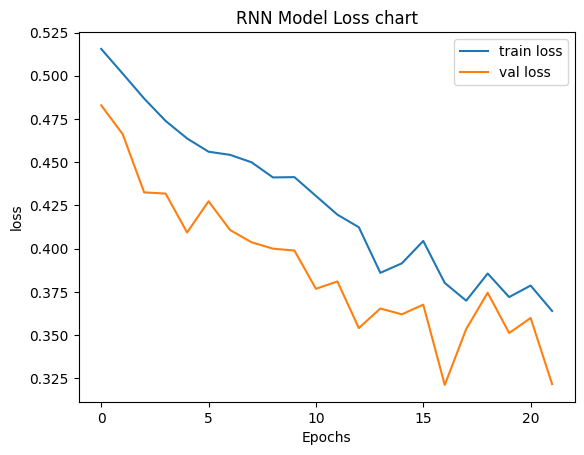

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("RNN Model Loss chart")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend(["train loss", "val loss"], loc = "upper right")
plt.show()

Testing the RNN model with the resampled data

In [ ]:
# Measure the training time and implement early stoping --this is comparing the performance for the imbalanced dataset
t = now()

early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

history_resampled = model.fit(X_resampled,y_resampled, batch_size=300, epochs=50, verbose=2,
                         validation_data=(valid_x,valid_y),
                         callbacks = [early_stopping])
print('Training time: %s' % (now() - t))

Epoch 1/50
10/10 - 314s - loss: 0.1982 - precision: 0.9143 - recall: 0.9309 - accuracy: 0.9218 - val_loss: 0.1920 - val_precision: 0.9400 - val_recall: 0.9675 - val_accuracy: 0.9254 - 314s/epoch - 31s/step
Epoch 2/50
10/10 - 313s - loss: 0.1882 - precision: 0.9277 - recall: 0.9225 - accuracy: 0.9253 - val_loss: 0.1934 - val_precision: 0.9391 - val_recall: 0.9772 - val_accuracy: 0.9319 - 313s/epoch - 31s/step
Epoch 3/50
10/10 - 313s - loss: 0.1824 - precision: 0.9191 - recall: 0.9358 - accuracy: 0.9267 - val_loss: 0.1899 - val_precision: 0.9446 - val_recall: 0.9707 - val_accuracy: 0.9319 - 313s/epoch - 31s/step
Epoch 4/50
10/10 - 313s - loss: 0.1671 - precision: 0.9370 - recall: 0.9344 - accuracy: 0.9358 - val_loss: 0.2021 - val_precision: 0.9525 - val_recall: 0.9463 - val_accuracy: 0.9203 - 313s/epoch - 31s/step
Epoch 5/50
10/10 - 313s - loss: 0.1789 - precision: 0.9294 - recall: 0.9288 - accuracy: 0.9291 - val_loss: 0.1982 - val_precision: 0.9511 - val_recall: 0.9496 - val_accuracy: 0

In [ ]:
# Get the maximum validation accuracy and its epoch
max_val_acc = max(history_resampled.history['val_accuracy'])
best_epoch = history_resampled.history['val_accuracy'].index(max_val_acc) + 1

# Get precision and recall corresponding to the best epoch
precision_at_best_epoch = history_resampled.history['val_precision'][best_epoch - 1]
recall_at_best_epoch = history_resampled.history['val_recall'][best_epoch - 1]

# Print or use the results
print(f"Best Validation Accuracy: {max_val_acc} at Epoch {best_epoch}")
print(f"Precision at Best Epoch: {precision_at_best_epoch}")
print(f"Recall at Best Epoch: {recall_at_best_epoch}")

In [ ]:
plt.plot(history_resampled.history["accuracy"])
plt.plot(history_resampled.history["val_accuracy"])
plt.title("RNN Model Accuracy with balanced data")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "val"], loc = "upper right")
plt.show()

In [ ]:
plt.plot(history_resampled.history["loss"])
plt.plot(history_resampled.history["val_loss"])
plt.title("RNN Model Loss with balanced data")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend(["train loss", "val loss"], loc = "upper right")
plt.show()

In [ ]:
from keras.layers import Conv1D,Conv2D

Building a CNN model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, Conv1D, LeakyReLU, Dropout, Flatten, Dense, Activation

dropout_rate = 0.25  # You might have defined this elsewhere in your code

model_CNN = Sequential()

# Masking layer to handle sequences with variable lengths
model_CNN.add(Masking(mask_value=0.0, input_shape=(500, 75)))

# First Conv1D layer
model_CNN.add(Conv1D(60, 5, padding='same', strides=2))
model_CNN.add(LeakyReLU())
model_CNN.add(Dropout(dropout_rate))

# Second Conv1D layer
model_CNN.add(Conv1D(30, 3, padding='same', strides=2))
model_CNN.add(LeakyReLU())
model_CNN.add(Dropout(dropout_rate))

# Third Conv1D layer
model_CNN.add(Conv1D(10, 3, padding='same'))
model_CNN.add(LeakyReLU())
model_CNN.add(Dropout(dropout_rate))

# Flatten layer to transition from 3D to 1D
model_CNN.add(Flatten())

# Dense layer for classification
model_CNN.add(Dense(1))
model_CNN.add(Activation('sigmoid'))


In [ ]:
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 500, 75)           0         
                                                                 
 conv1d (Conv1D)             (None, 250, 60)           22560     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 250, 60)           0         
                                                                 
 dropout_3 (Dropout)         (None, 250, 60)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 125, 30)           5430      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 125, 30)           0         
                                                                 
 dropout_4 (Dropout)         (None, 125, 30)          

In [ ]:
#keras.utils.plot_model(model_CNN, "The_CNN.png",show_shapes = True)

In [ ]:
metrics = [
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.BinaryAccuracy(name = 'accuracy')
]

In [ ]:
optimizer = Adam(learning_rate=0.001)
model_CNN.compile(loss='binary_crossentropy', optimizer=Adam(),metrics = metrics,run_eagerly=True)
#model2.summary()

In [ ]:
# Measure the training time and implement early stoping
t = now()

early_stopping = EarlyStopping(monitor='val_loss', patience = 10)

CNN_history = model_CNN.fit(train_x,train_y, batch_size=100, epochs=50, verbose=2,
                         validation_data=(valid_x,valid_y),
                         callbacks = [early_stopping])
print('Training time: %s' % (now() - t))

In [ ]:
t = now()

early_stopping = EarlyStopping(monitor='val_loss', patience = 10)
CNN_history_balanced = model_CNN.fit(X_resampled,y_resampled, batch_size=200, epochs=50, verbose=2,
                         validation_data=(valid_x,valid_y),
                         callbacks = [early_stopping])
print('Training time: %s' % (now() - t))

Epoch 1/50
15/15 - 6s - loss: 0.5814 - precision: 0.6624 - recall: 0.6823 - accuracy: 0.6672 - val_loss: 0.4810 - val_precision: 0.8932 - val_recall: 0.8699 - val_accuracy: 0.8149 - 6s/epoch - 372ms/step
Epoch 2/50
15/15 - 1s - loss: 0.5199 - precision: 0.6834 - recall: 0.8575 - accuracy: 0.7301 - val_loss: 0.4554 - val_precision: 0.9016 - val_recall: 0.8943 - val_accuracy: 0.8393 - 968ms/epoch - 65ms/step
Epoch 3/50
15/15 - 1s - loss: 0.4971 - precision: 0.7108 - recall: 0.8324 - accuracy: 0.7469 - val_loss: 0.4077 - val_precision: 0.8926 - val_recall: 0.9057 - val_accuracy: 0.8393 - 1s/epoch - 67ms/step
Epoch 4/50
15/15 - 1s - loss: 0.4807 - precision: 0.7418 - recall: 0.8184 - accuracy: 0.7668 - val_loss: 0.4615 - val_precision: 0.9366 - val_recall: 0.8407 - val_accuracy: 0.8290 - 954ms/epoch - 64ms/step
Epoch 5/50
15/15 - 1s - loss: 0.4563 - precision: 0.7637 - recall: 0.8191 - accuracy: 0.7828 - val_loss: 0.3643 - val_precision: 0.9257 - val_recall: 0.8911 - val_accuracy: 0.8573 -

In [ ]:
# Get the maximum validation accuracy and its epoch
max_val_acc = max(CNN_history_balanced.history['val_accuracy'])
best_epoch = CNN_history_balanced.history['val_accuracy'].index(max_val_acc) + 1

# Get precision and recall corresponding to the best epoch
precision_at_best_epoch = CNN_history_balanced.history['val_precision'][best_epoch - 1]
recall_at_best_epoch = CNN_history_balanced.history['val_recall'][best_epoch - 1]

# Print or use the results
print(f"Best Validation Accuracy: {max_val_acc} at Epoch {best_epoch}")
print(f"Precision at Best Epoch: {precision_at_best_epoch}")
print(f"Recall at Best Epoch: {recall_at_best_epoch}")

Best Validation Accuracy: 0.903598964214325 at Epoch 22
Precision at Best Epoch: 0.9576271176338196
Recall at Best Epoch: 0.9186992049217224


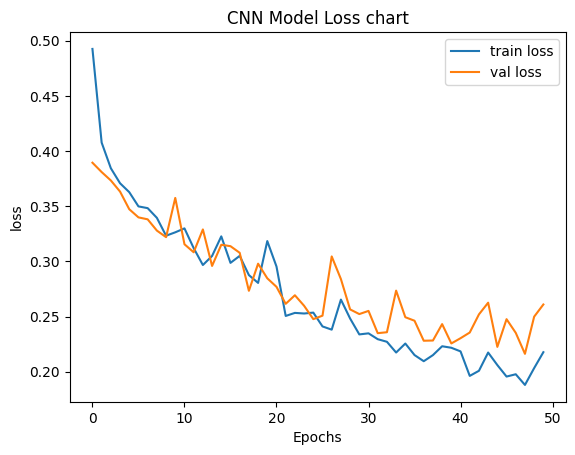

In [ ]:
plt.plot(CNN_history.history["loss"])
plt.plot(CNN_history.history["val_loss"])
plt.title("CNN Model Loss chart")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend(["train loss", "val loss"], loc = "upper right")
plt.show()

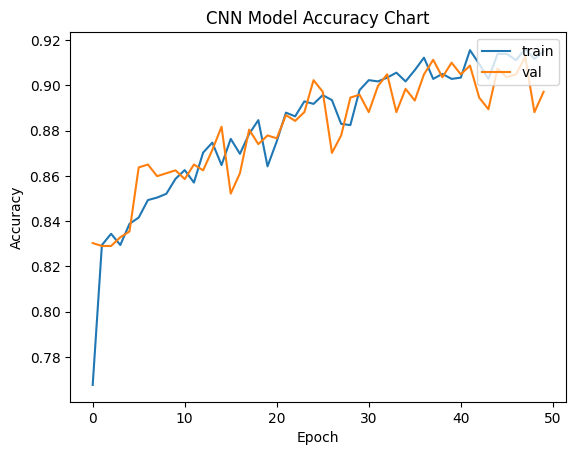

In [ ]:
plt.plot(CNN_history.history["accuracy"])
plt.plot(CNN_history.history["val_accuracy"])
plt.title("CNN Model Accuracy Chart")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "val"], loc = "upper right")
plt.show()

In [ ]:
plt.plot(CNN_history.history["loss"])
plt.plot(CNN_history.history["val_loss"])
plt.title("CNN Model Accuracy with imbalanced data")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "val"], loc = "upper right")
plt.show()

Testing the CNN Model with the resampled data

In [ ]:
# Measure the training time and implement early stoping,comparing the performance with the imbalanced dataset
t = now()

early_stopping = EarlyStopping(monitor='val_loss', patience = 10)

CNN_history2 = model2.fit(X_resampled,y_resampled, batch_size=100, epochs=50, verbose=2,
                         validation_data=(valid_x,valid_y),
                         callbacks = [early_stopping])
print('Training time: %s' % (now() - t))

In [ ]:
plt.plot(CNN_history2.history["accuracy"])
plt.plot(CNN_history2.history["val_accuracy"])
plt.title("CNN Model Accuracy with balanced data")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "val"], loc = "upper right")
plt.show()

In [ ]:
#building an LSTM model to see the difference

# Building an improved LSTM network
model_lstm = Sequential()
model_lstm.add(Masking(mask_value=0.0, input_shape=(500, 75)))  # Update num_joints accordingly
model_lstm.add(Bidirectional(LSTM(100, return_sequences=True)))
model_lstm.add(Dropout(0.5))
model_lstm.add(Bidirectional(LSTM(80,return_sequences=True)))
model_lstm.add(Dropout(0.5))
model_lstm.add(Bidirectional(LSTM(60,return_sequences=True)))
model_lstm.add(Dropout(0.5))
model_lstm.add(Bidirectional(LSTM(30,return_sequences=True)))
model_lstm.add(Dropout(0.5))
model_lstm.add(Bidirectional(LSTM(10)))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1, activation='sigmoid'))


optimizer = Adam(learning_rate=0.001)
model_lstm.compile(loss='binary_crossentropy', optimizer= optimizer, metrics= metrics)
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_3 (Masking)         (None, 500, 75)           0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 500, 200)          140800    
 onal)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 500, 200)          0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 500, 160)          179840    
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 500, 160)          0         
                                                                 
 bidirectional_9 (Bidirecti  (None, 500, 120)         

In [ ]:
# Measure the training time and implement early stoping
t = now()

early_stopping = EarlyStopping(monitor='val_loss', patience = 5,restore_best_weights=True)

lstm_history = model_lstm.fit(train_x,train_y, batch_size=300, epochs=50, verbose=2,
                         validation_data=(valid_x,valid_y),
                         callbacks = [early_stopping])
print('Training time: %s' % (now() - t))

Epoch 1/50
7/7 - 3s - loss: 0.3525 - precision: 0.8718 - recall: 0.9309 - accuracy: 0.8372 - val_loss: 0.3251 - val_precision: 0.8690 - val_recall: 0.9707 - val_accuracy: 0.8612 - 3s/epoch - 465ms/step
Epoch 2/50
7/7 - 3s - loss: 0.3461 - precision: 0.8795 - recall: 0.9476 - accuracy: 0.8560 - val_loss: 0.3374 - val_precision: 0.8602 - val_recall: 0.9902 - val_accuracy: 0.8650 - 3s/epoch - 385ms/step
Epoch 3/50
7/7 - 3s - loss: 0.3733 - precision: 0.8908 - recall: 0.8883 - accuracy: 0.8256 - val_loss: 0.3554 - val_precision: 0.8528 - val_recall: 0.9610 - val_accuracy: 0.8380 - 3s/epoch - 382ms/step
Epoch 4/50
7/7 - 3s - loss: 0.3580 - precision: 0.8634 - recall: 0.9490 - accuracy: 0.8411 - val_loss: 0.3052 - val_precision: 0.9125 - val_recall: 0.9154 - val_accuracy: 0.8638 - 3s/epoch - 386ms/step
Epoch 5/50
7/7 - 3s - loss: 0.3345 - precision: 0.8625 - recall: 0.9546 - accuracy: 0.8438 - val_loss: 0.3318 - val_precision: 0.9556 - val_recall: 0.8390 - val_accuracy: 0.8419 - 3s/epoch - 4

In [ ]:
# Get the maximum validation accuracy and its epoch
max_val_acc = max(lstm_history.history['val_accuracy'])
best_epoch = lstm_history.history['val_accuracy'].index(max_val_acc) + 1

# Get precision and recall corresponding to the best epoch
precision_at_best_epoch = lstm_history.history['val_precision'][best_epoch - 1]
recall_at_best_epoch = lstm_history.history['val_recall'][best_epoch - 1]

# Print or use the results
print(f"Best Validation Accuracy: {max_val_acc} at Epoch {best_epoch}")
print(f"Precision at Best Epoch: {precision_at_best_epoch}")
print(f"Recall at Best Epoch: {recall_at_best_epoch}")

Best Validation Accuracy: 0.8650385737419128 at Epoch 2
Precision at Best Epoch: 0.8601694703102112
Recall at Best Epoch: 0.9902439117431641


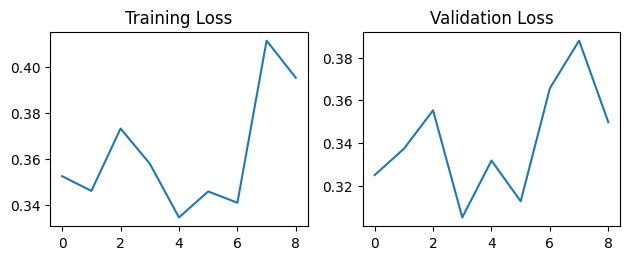

In [ ]:
 plt.figure(1)
 plt.subplot(221)
 plt.plot(lstm_history.history['loss'])
 plt.title('Training Loss')
 plt.subplot(222)
 plt.plot(lstm_history.history['val_loss'])
 plt.title('Validation Loss')
 plt.tight_layout()
 plt.show()

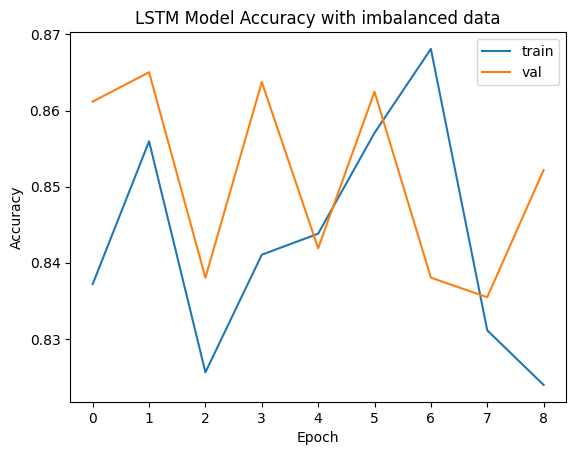

In [ ]:
plt.plot(lstm_history.history["accuracy"])
plt.plot(lstm_history.history["val_accuracy"])
plt.title("LSTM Model Accuracy with imbalanced data")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "val"], loc = "upper right")
plt.show()

Attempting Transfer learning

In [ ]:
base_model = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(1812, 500, 75),
    include_top=False
)
#ValueError: The input must have 3 channels; Received `input_shape=(1812, 500, 75)`

In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras import regularizers



# Create a Sequential model
model_gru = Sequential()

# Add a GRU layer with a certain number of units and specify the input shape
model_gru.add((Masking(mask_value=0.0, input_shape=(500, 75))))
model_gru.add(GRU(units=60,return_sequences=True, kernel_regularizer=regularizers.l2(0.01),recurrent_dropout=0.2))
# You can adjust the number of units based on your specific task and data
model_gru.add(GRU(units = 40,return_sequences=True))
# Add another GRU layer if needed
model_gru.add(Dropout(0.2))
model_gru.add(GRU(units=20,return_sequences=True))
model_gru.add(Dropout(0.2))

model_gru.add(GRU(units=10))
# Add a Dense layer for the output
model_gru.add(Dense(units=1, activation='sigmoid'))
# Adjust the number of units in the output layer based on your task (e.g., binary classification)
optimizer = Adam(learning_rate=0.001)
# Compile the model
model_gru.compile(optimizer=optimizer, loss='binary_crossentropy', metrics= metrics)

# Display the model summary
model_gru.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 500, 75)           0         
                                                                 
 gru (GRU)                   (None, 500, 60)           24660     
                                                                 
 gru_1 (GRU)                 (None, 500, 40)           12240     
                                                                 
 dropout_6 (Dropout)         (None, 500, 40)           0         
                                                                 
 gru_2 (GRU)                 (None, 500, 20)           3720      
                                                                 
 dropout_7 (Dropout)         (None, 500, 20)           0         
                                                                 
 gru_3 (GRU)                 (None, 10)               

In [ ]:
#keras.utils.plot_model(model_gru, "The_GRU.png",show_shapes = True)

In [ ]:
t = now()

early_stopping = EarlyStopping(monitor='val_loss', patience = 5,restore_best_weights=True)

gru_history = model_gru.fit(train_x,train_y, batch_size=300, epochs=50, verbose=2,
                         validation_data=(valid_x,valid_y),
                         callbacks = [early_stopping])
print('Training time: %s' % (now() - t))

Epoch 1/50


KeyboardInterrupt: 

In [ ]:
t = now()

early_stopping = EarlyStopping(monitor='val_loss', patience = 5,restore_best_weights=True)
gru_history_balanced = model_gru.fit(X_resampled,y_resampled, batch_size=200, epochs=50, verbose=2,
                         validation_data=(valid_x,valid_y),
                         callbacks = [early_stopping])
print('Training time: %s' % (now() - t))

Epoch 1/50
15/15 - 34s - loss: 1.5647 - precision: 0.6775 - recall: 0.7158 - accuracy: 0.6875 - val_loss: 1.2922 - val_precision: 0.8370 - val_recall: 0.9187 - val_accuracy: 0.7943 - 34s/epoch - 2s/step
Epoch 2/50
15/15 - 20s - loss: 1.2396 - precision: 0.7616 - recall: 0.7542 - accuracy: 0.7591 - val_loss: 1.0343 - val_precision: 0.8527 - val_recall: 0.8943 - val_accuracy: 0.7943 - 20s/epoch - 1s/step
Epoch 3/50
15/15 - 20s - loss: 0.9977 - precision: 0.8236 - recall: 0.7661 - accuracy: 0.8010 - val_loss: 0.8866 - val_precision: 0.9097 - val_recall: 0.8683 - val_accuracy: 0.8278 - 20s/epoch - 1s/step
Epoch 4/50
15/15 - 20s - loss: 0.8412 - precision: 0.8415 - recall: 0.7898 - accuracy: 0.8205 - val_loss: 0.7358 - val_precision: 0.8896 - val_recall: 0.9171 - val_accuracy: 0.8445 - 20s/epoch - 1s/step
Epoch 5/50
15/15 - 20s - loss: 0.7324 - precision: 0.8326 - recall: 0.8268 - accuracy: 0.8303 - val_loss: 0.6632 - val_precision: 0.9233 - val_recall: 0.8813 - val_accuracy: 0.8483 - 20s/e

In [ ]:
# Get the maximum validation accuracy and its epoch
max_val_acc = max(gru_history_balanced.history['val_accuracy'])
best_epoch = gru_history_balanced.history['val_accuracy'].index(max_val_acc) + 1

# Get precision and recall corresponding to the best epoch
precision_at_best_epoch = gru_history_balanced.history['val_precision'][best_epoch - 1]
recall_at_best_epoch = gru_history_balanced.history['val_recall'][best_epoch - 1]

# Print or use the results
print(f"Best Validation Accuracy: {max_val_acc} at Epoch {best_epoch}")
print(f"Precision at Best Epoch: {precision_at_best_epoch}")
print(f"Recall at Best Epoch: {recall_at_best_epoch}")

Best Validation Accuracy: 0.9344472885131836 at Epoch 23
Precision at Best Epoch: 0.9533762335777283
Recall at Best Epoch: 0.9642276167869568


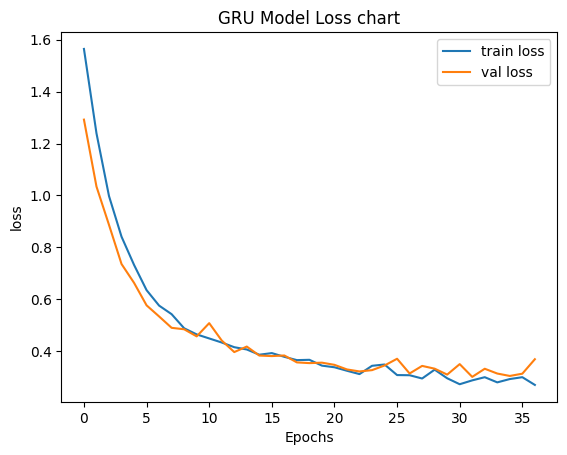

In [ ]:
plt.plot(gru_history_balanced.history["loss"])
plt.plot(gru_history_balanced.history["val_loss"])
plt.title("GRU Model Loss chart")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend(["train loss", "val loss"], loc = "upper right")
plt.show()

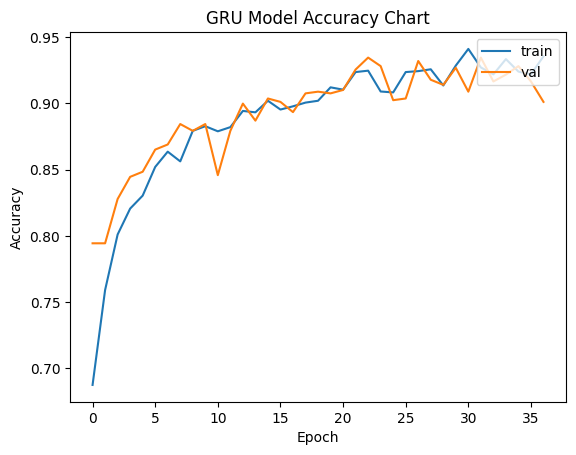

In [ ]:
plt.plot(gru_history_balanced.history["accuracy"])
plt.plot(gru_history_balanced.history["val_accuracy"])
plt.title("GRU Model Accuracy Chart")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "val"], loc = "upper right")
plt.show()